In [1]:
# 모듈 임포트
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 경로 설정
%cd ../input/covid19-image-dataset/Covid19-dataset

/kaggle/input/covid19-image-dataset/Covid19-dataset


In [8]:
# Custom Dataset 구현
class CustomDataset(Dataset):
    def readData(self):
        all_images = []
        all_labels = []
        
        class_names = os.walk(self.dataset_path).__next__()[1]
        
        for idx,class_name in enumerate(class_names):
            img_dir = os.path.join(self.dataset_path,class_name)
            img_names = os.walk(img_dir).__next__()[2]
            print('class name: {}, label: {}, num_images: {}'.format(class_name, idx, len(img_names)))
            
            for img_file in img_names:
                img_path = os.path.join(img_dir,img_file)
                image = Image.open(img_path)
                if image is not None:
                    all_images.append(img_path)
                    all_labels.append(idx)
                    
        return all_images, all_labels, len(all_images), len(class_names)
        
    def __init__(self, dataset_path, transforms=transforms.Resize((256,256))):
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.images, self.labels, self.num_images, self.num_classes = self.readData()
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = Image.open(image)
        image = image.convert('L') # gray scale
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {'image':image, 'label':label}
    
    def __len__(self):
        return self.num_images
        

check test dataset...
class name: Normal, label: 0, num_images: 20
class name: Viral Pneumonia, label: 1, num_images: 20
class name: Covid, label: 2, num_images: 26
test size: 66


check total dataset(train + val)...
class name: Normal, label: 0, num_images: 70
class name: Viral Pneumonia, label: 1, num_images: 70
class name: Covid, label: 2, num_images: 111


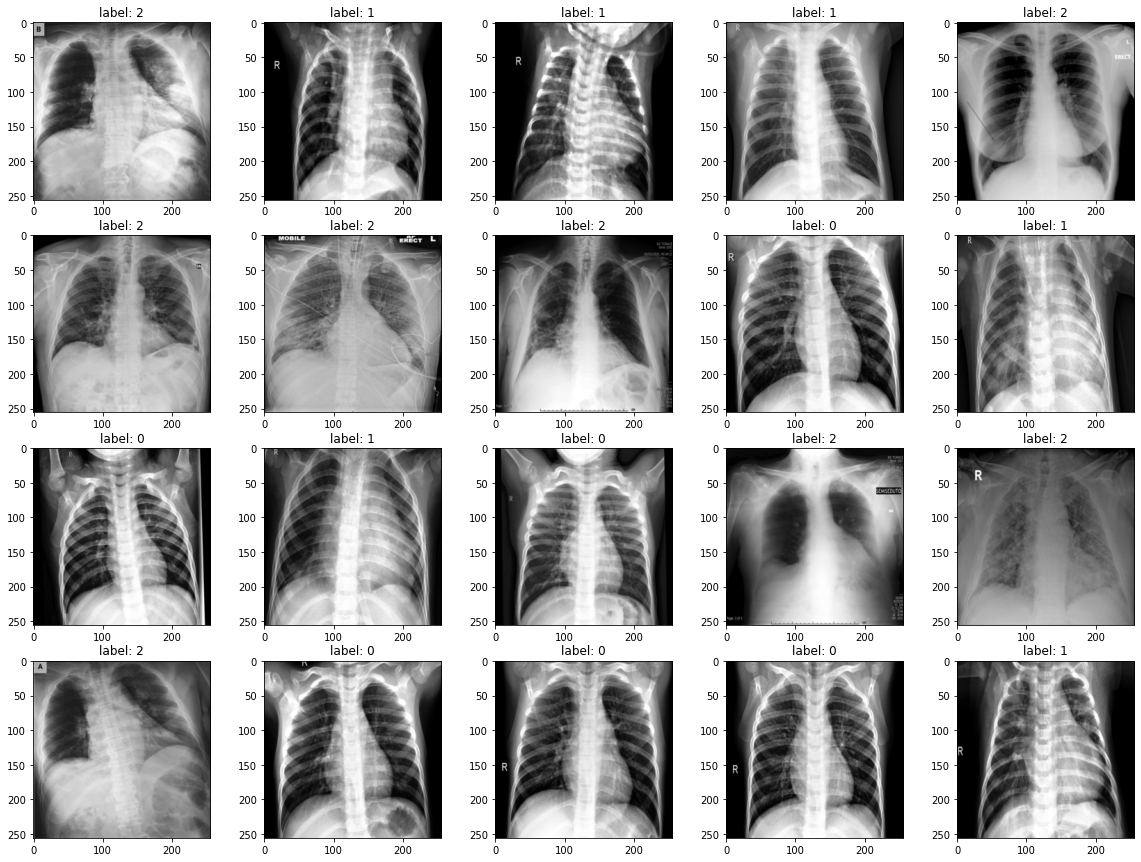

In [20]:
# 데이터 시각화
print('check test dataset...')
data_transforms = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_dataset = CustomDataset('./test',data_transforms)
print('test size: {}'.format(test_dataset.num_images))
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

plt.figure(figsize=(20,15))
to_image = transforms.ToPILImage()
for item in test_loader:
    images = item['image']
    labels = item['label']
    
    for idx, img in enumerate(images):
        img = to_image(img)
        plt.subplot(4,5,idx+1)
        plt.title('label: {}'.format(labels[idx]))
        plt.imshow(img,cmap='gray')
    
    break


print('\n')
print('check total dataset(train + val)...')
total_dataset = CustomDataset('./train', data_transforms)
